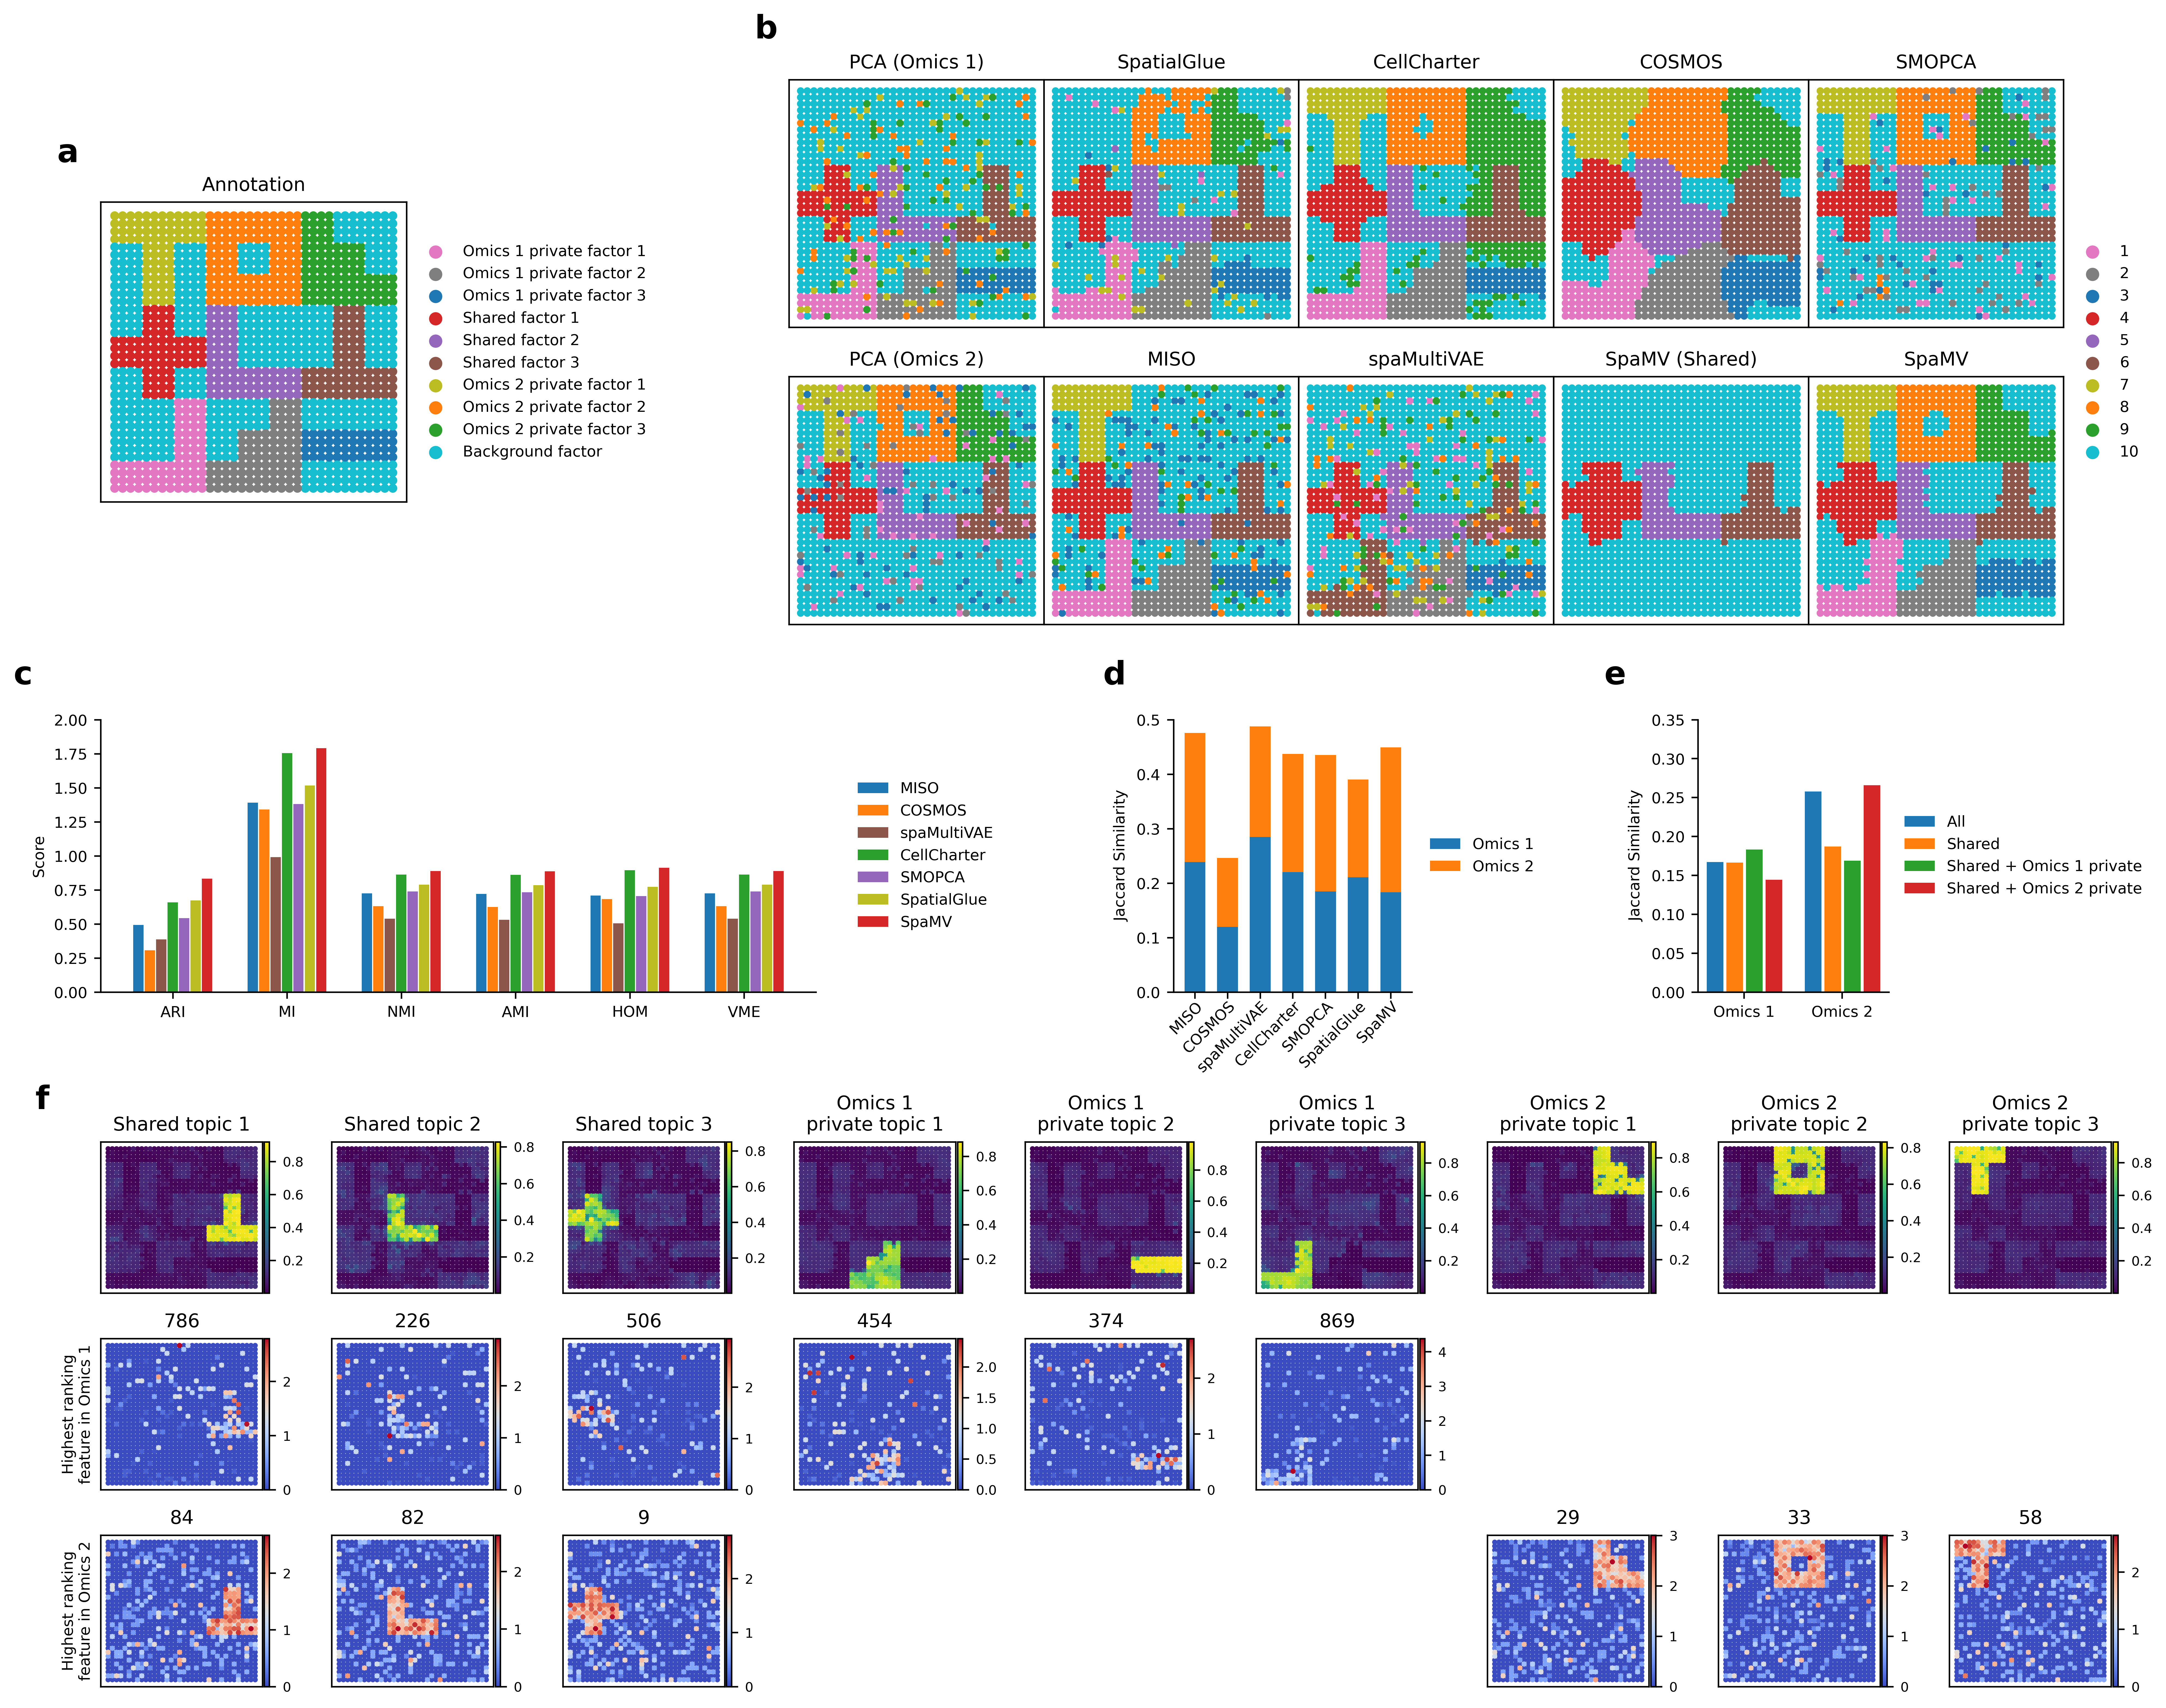

In [ ]:
import os, sys
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import scanpy as sc
from scanpy.plotting import embedding
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec

# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(current_dir))
from SpaMV.metrics import compute_supervised_scores, compute_jaccard, compute_topic_coherence
from SpaMV.utils import clr_normalize_each_cell

plt.rcParams.update({'font.size': 9})
plt.rc('font', size=8)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)

def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

# Define the softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return e_x / e_x.sum()

n_topics = 10
gt_size = 90
cluster_size = 60
dr_size = 30
width = 16
height = 13
k = 50
methods = ['PCA_Omics1', 'PCA_Omics2', 'SpatialGlue', 'CellCharter', 'COSMOS', 'SMOPCA', 'MISO', 'spaMultiVAE', 'SpaMV (Shared)', 'SpaMV']
clustering_scale = {'top': 1 - .5 / height, 'bottom': 1 - 4.5 / height, 'left': 0.05, 'right': .98}
score_scale = {'top': 1 - 5.2 / height, 'bottom': 1 - 7.2 / height, 'left': 0.05, 'right': .98}
dr_scale = {'top': 1 - 8.3 / height, 'bottom': 1 - 12.3 / height, 'left': 0.05, 'right': .98}
# load simulated dataset
# 'Simulation_1', 'Simulation_2', '3_Simulation'
for dataset in ['Simulation_1', 'Simulation_2', 'Simulation_3']:
    data_rna = sc.read_h5ad('../Dataset/' + dataset + '/adata_RNA.h5ad')
    sc.pp.normalize_total(data_rna)
    sc.pp.pca(data_rna, n_comps=50)
    data_pro = sc.read_h5ad('../Dataset/' + dataset + '/adata_ADT.h5ad')
    data_pro = clr_normalize_each_cell(data_pro)
    sc.pp.pca(data_pro, n_comps=50)

    ###############################################################################################################################
    # plot clustering results
    if 'Simulation_1' in dataset:
        data_rna.obs['cluster'].replace(
            {0: 'Omics 2 private factor', 1: 'Shared factor 1', 2: 'Shared factor 2', 3: 'Shared factor 3',
             4: 'Shared factor 4', 5: 'Shared factor 5', 6: 'Shared factor 6', 7: 'Shared factor 7',
             8: 'Omics 1 private factor', 9: 'Background factor'}, inplace=True)
        data_rna.obs['cluster'] = pd.Categorical(data_rna.obs['cluster'],
                                                 categories=['Omics 1 private factor', 'Shared factor 1',
                                                             'Shared factor 2', 'Shared factor 3', 'Shared factor 4',
                                                             'Shared factor 5', 'Shared factor 6', 'Shared factor 7',
                                                             'Omics 2 private factor', 'Background factor'],
                                                 ordered=True)
    elif 'Simulation_2' in dataset:
        data_rna.obs['cluster'].replace(
            {0: 'Shared factor 1', 1: 'Omics 2 private factor 1', 2: 'Shared factor 2', 3: 'Omics 2 private factor 2',
             4: 'Shared factor 3', 5: 'Omics 1 private factor 1', 6: 'Shared factor 4', 7: 'Omics 1 private factor 2',
             8: 'Shared factor 5', 9: 'Background factor'}, inplace=True)
        data_rna.obs['cluster'] = pd.Categorical(data_rna.obs['cluster'],
                                                 categories=['Omics 1 private factor 1', 'Omics 1 private factor 2',
                                                             'Shared factor 1', 'Shared factor 2', 'Shared factor 3',
                                                             'Shared factor 4', 'Shared factor 5',
                                                             'Omics 2 private factor 1', 'Omics 2 private factor 2',
                                                             'Background factor'], ordered=True)
    else:
        data_rna.obs['cluster'].replace(
            {0: 'Omics 2 private factor 1', 1: 'Omics 2 private factor 2', 2: 'Omics 2 private factor 3',
             3: 'Shared factor 1', 4: 'Shared factor 2', 5: 'Shared factor 3', 6: 'Omics 1 private factor 1',
             7: 'Omics 1 private factor 2', 8: 'Omics 1 private factor 3', 9: 'Background factor'}, inplace=True)
        data_rna.obs['cluster'] = pd.Categorical(data_rna.obs['cluster'],
                                                 categories=['Omics 1 private factor 1', 'Omics 1 private factor 2',
                                                             'Omics 1 private factor 3', 'Shared factor 1',
                                                             'Shared factor 2', 'Shared factor 3',
                                                             'Omics 2 private factor 1', 'Omics 2 private factor 2',
                                                             'Omics 2 private factor 3', 'Background factor'],
                                                 ordered=True)

    fig = plt.figure(figsize=(width, height), dpi=500)
    # TODO：调height_ratios让annotation居中
    spec_clustering = GridSpec(4, 10, width_ratios=[0, 1.2, 1.2, 3, 2, 2, 2, 2, 2, .5], height_ratios=[.7, 1.2, 1.2, .7],
                               wspace=0, hspace=.5)
    spec_clustering.update(**clustering_scale)

    data_results = {}
    clustering_supervised_results = {}
    clustering_unsupervised_results = {}
    f_dict = {}
    f_dict['Annotation'] = plt.subplot(spec_clustering[1:3, 1:3])
    if dataset == 'Simulation_1':
        embedding(data_rna, color='cluster', ax=f_dict['Annotation'], basis='spatial', title='Annotation', show=False, size=gt_size)
    elif dataset == 'Simulation_2':
        sim2_palette = {'Omics 1 private factor 1':'#8c564b', 'Omics 1 private factor 2':'#7f7f7f', 'Shared factor 1':'#bcbd22', 'Shared factor 2':'#2ca02c', 'Shared factor 3':'#9467bd',
        'Shared factor 4':'#e377c2', 'Shared factor 5':'#1f77b4', 'Omics 2 private factor 1':'#ff7f0e', 'Omics 2 private factor 2':'#d62728', 'Background factor':'#17becf',}
        embedding(data_rna, color='cluster', ax=f_dict['Annotation'], basis='spatial', title='Annotation', show=False,
                 size=gt_size, palette=sim2_palette)
    else:
        sim3_palette = {'Omics 1 private factor 1':'#e377c2', 'Omics 1 private factor 2':'#7f7f7f', 'Omics 1 private factor 3':'#1f77b4', 'Shared factor 1':'#d62728', 'Shared factor 2':'#9467bd',
        'Shared factor 3':'#8c564b', 'Omics 2 private factor 1':'#bcbd22', 'Omics 2 private factor 2':'#ff7f0e', 'Omics 2 private factor 3':'#2ca02c', 'Background factor':'#17becf'}
        embedding(data_rna, color='cluster', ax=f_dict['Annotation'], basis='spatial', title='Annotation', show=False,
                 size=gt_size, palette=sim3_palette)
    for method in methods:
        if method == 'SpaMV (Shared)':
            data_results[method] = sc.read_h5ad('../Results/' + dataset + '/SpaMV_shared.h5ad')
        else:
            data_results[method] = sc.read_h5ad('../Results/' + dataset + '/' + method + '.h5ad')
        if not method.startswith('PCA'):
            clustering_supervised_results[method] = compute_supervised_scores(data_results[method], method.split('_')[0])
            data_rna.obsm[method] = data_results[method].obsm[method]
            data_pro.obsm[method] = data_results[method].obsm[method]
            clustering_unsupervised_results[method] = {'Omics 1': compute_jaccard(data_rna, method, k=k) - .05 if method in ['MISO', 'spaMultiVAE'] and dataset == '3_Simulation' else compute_jaccard(data_rna, method, k=k),
                                                       'Omics 2': compute_jaccard(data_pro, method, k=k)}
        if method == 'PCA_Omics1':
            f_dict[method] = plt.subplot(spec_clustering[:2, 4])
        elif method == 'SpatialGlue':
            f_dict[method] = plt.subplot(spec_clustering[:2, 5])
        elif method == 'CellCharter':
            f_dict[method] = plt.subplot(spec_clustering[:2, 6])
        elif method == 'COSMOS':
            f_dict[method] = plt.subplot(spec_clustering[:2, 7])
        elif method == 'SMOPCA':
            f_dict[method] = plt.subplot(spec_clustering[:2, 8])
        elif method == 'PCA_Omics2':
            f_dict[method] = plt.subplot(spec_clustering[2:, 4])
        elif method == 'MISO':
            f_dict[method] = plt.subplot(spec_clustering[2:, 5])
        elif method == 'spaMultiVAE':
            f_dict[method] = plt.subplot(spec_clustering[2:, 6])
        elif method == 'SpaMV (Shared)':
            f_dict[method] = plt.subplot(spec_clustering[2:, 7])
        elif method == 'SpaMV':
            f_dict[method] = plt.subplot(spec_clustering[2:, 8])
        SpaMV_2_palette = {1:'#8c564b', 2:'#7f7f7f', 3:'#bcbd22', 4:'#2ca02c', 5:'#9467bd',
                6:'#e377c2', 7:'#1f77b4', 8:'#ff7f0e', 9:'#d62728', 10:'#17becf'}
        SpaMV_3_palette = {1:'#e377c2', 2:'#7f7f7f', 3:'#1f77b4', 4:'#d62728', 5:'#9467bd',
        6:'#8c564b', 7:'#bcbd22', 8:'#ff7f0e', 9:'#2ca02c', 10:'#17becf'}

        if method == 'SpaMV':
            if dataset == 'Simulation_1':
                mapping = {1:10, 2:5, 3:8, 4:6, 5:3, 6:4, 7:1, 8:9, 9:2, 10:7}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size)
            elif dataset == 'Simulation_2':
                mapping = {1:10, 2:5, 3:2, 4:1, 5:4, 6:9, 7:7, 8:3, 9:8, 10:6}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size, palette=SpaMV_2_palette)
            else:
                mapping = {1:10, 2:5, 3:8, 4:2, 5:6, 6:9, 7:4, 8:3, 9:7, 10:1}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size, palette=SpaMV_3_palette)
        elif method == 'SpaMV (Shared)':
            if dataset == 'Simulation_1':
                # mapping = {3:10, 5:2, 4:3, 6:4, 8:5, 2:6, 7:7, 1:8}
                # data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                # data_results[method].obs[method] = data_results[method].obs[method].cat.add_categories([1, 9])
                # pl = {1:'#8c564b', 2:'#7f7f7f', 3:'#bcbd22', 4:'#2ca02c', 5:'#9467bd', 6:'#e377c2', 7:'#1f77b4', 8:'#ff7f0e', 9:'#d62728', 10:'#17becf'}
                pl = {1:'#17becf', 2:'#9467bd', 3:'#ff7f0e', 4:'#7f7f7f', 5:'#8c564b', 6:'#2ca02c', 7:'#d62728', 8:'#e377c2'}
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size, palette=pl)
            elif dataset == 'Simulation_2':
                pl = {1:'#1f77b4', 2:'#17becf', 3:'#9467bd', 4:'#2ca02c', 5:'#bcbd22', 6:'#e377c2', 7:'#1f77b4', 8:'#ff7f0e', 9:'#d62728', 10:'#1f77b4'}
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size, palette=pl)
            else:
                pl = {1:'#17becf', 2:'#9467bd', 3:'#8c564b', 4:'#d62728'}
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size, palette=pl)
        elif 'PCA_Omics1' in method:
            if dataset == 'Simulation_1':
                # PCA_Omics1_palette = {1:'#17becf', 2:'#9467bd', 3:'#7f7f7f', 4:'#8c564b', 5:'#2ca02c',
                # 6:'#bcbd22', 7:'#d62728', 8:'#1f77b4', 9:'#ff7f0e', 10:'#e377c2',}
                mapping = {1:10, 2:5, 3:8, 4:6, 5:3, 6:9, 7:4, 8:1, 9:2, 10:7}
                data_results[method].obs['PCA (Omics 1)'] = data_results[method].obs['PCA (Omics 1)'].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color='PCA (Omics 1)', ax=f_dict[method], basis='spatial',
                         legend_loc='none', show=False, size=cluster_size)
            elif dataset == 'Simulation_2':
                mapping = {1:10, 2:5, 3:8, 4:2, 5:1, 6:4, 7:9, 8:7, 9:3, 10:6}
                data_results[method].obs['PCA (Omics 1)'] = data_results[method].obs['PCA (Omics 1)'].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color='PCA (Omics 1)', ax=f_dict[method], basis='spatial',
                         legend_loc='none', show=False, size=cluster_size, palette=SpaMV_2_palette)
            else:
                mapping = {1:10, 2:7, 3:5, 4:8, 5:2, 6:6, 7:9, 8:4, 9:3, 10:1}
                data_results[method].obs['PCA (Omics 1)'] = data_results[method].obs['PCA (Omics 1)'].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color='PCA (Omics 1)', ax=f_dict[method], basis='spatial',
                         legend_loc='none', show=False, size=cluster_size, palette=SpaMV_3_palette)

        elif 'PCA_Omics2' in method:
            if dataset == 'Simulation_1':
                # PCA_Omics2_palette = {1:'#17becf', 2:'#9467bd', 3:'#ff7f0e', 4:'#7f7f7f', 5:'#8c564b',
                # 6:'#2ca02c', 7:'#d62728', 8:'#1f77b4', 9:'#bcbd22', 10:'#e377c2',}
                mapping = {1:10, 2:5, 3:2, 4:8, 5:6, 6:3, 7:4, 8:1, 9:9, 10:7}
                data_results[method].obs['PCA (Omics 2)'] = data_results[method].obs['PCA (Omics 2)'].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color='PCA (Omics 2)', ax=f_dict[method], basis='spatial',
                         legend_loc='none', show=False, size=cluster_size)
            elif dataset == 'Simulation_2':
                mapping = {1:10, 2:5, 3:8, 4:1, 5:4, 6:9, 7:2, 8:7, 9:3, 10:6}
                data_results[method].obs['PCA (Omics 2)'] = data_results[method].obs['PCA (Omics 2)'].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color='PCA (Omics 2)', ax=f_dict[method], basis='spatial',
                         legend_loc='none', show=False, size=cluster_size, palette=SpaMV_2_palette)
            else:
                mapping = {1:10, 2:1, 3:5, 4:8, 5:2, 6:6, 7:9, 8:4, 9:3, 10:7}
                data_results[method].obs['PCA (Omics 2)'] = data_results[method].obs['PCA (Omics 2)'].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color='PCA (Omics 2)', ax=f_dict[method], basis='spatial',
                         legend_loc='none', show=False, size=cluster_size, palette=SpaMV_3_palette)

        elif method == 'SpatialGlue':
            if dataset == 'Simulation_1':
                # SpatialGlue_palette = {1:'#17becf', 2:'#9467bd', 3:'#7f7f7f', 4:'#8c564b', 5:'#2ca02c',
                # 6:'#d62728', 7:'#bcbd22', 8:'#ff7f0e', 9:'#1f77b4', 10:'#e377c2',}
                mapping = {1:10, 2:5, 3:8, 4:6, 5:3, 6:4, 7:9, 8:2, 9:1, 10:7}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      legend_loc='none', size=cluster_size)
            elif dataset == 'Simulation_2':
                mapping = {1:10, 2:8, 3:5, 4:2, 5:1, 6:9, 7:4, 8:7, 9:3, 10:6}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      legend_loc='none', size=cluster_size, palette=SpaMV_2_palette)
            else:
                mapping = {1:10, 2:5, 3:2, 4:6, 5:4, 6:7, 7:9, 8:3, 9:1, 10:8}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      legend_loc='none', size=cluster_size, palette=SpaMV_3_palette)

        elif method == 'CellCharter':
            if dataset == 'Simulation_1':
                # CellCharter_palette = {1:'#9467bd', 2:'#1f77b4', 3:'#7f7f7f', 4:'#8c564b', 5:'#e377c2',
                # 6:'#ff7f0e', 7:'#bcbd22', 8:'#2ca02c', 9:'#d62728', 10:'#17becf',}
                mapping = {1:5, 2:1, 3:8, 4:6, 5:7, 6:2, 7:9, 8:3, 9:4, 10:10}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                         legend_loc='none', size=cluster_size)
            elif dataset == 'Simulation_2':
                mapping = {1:1, 2:3, 3:8, 4:2, 5:10, 6:7, 7:9, 8:6, 9:4, 10:5}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                          legend_loc='none', size=cluster_size, palette=SpaMV_2_palette)
            else:
                mapping = {1:9, 2:4, 3:10, 4:2, 5:7, 6:6, 7:1, 8:5, 9:8, 10:3}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      legend_loc='none', size=cluster_size, palette=SpaMV_3_palette)

        elif method == 'COSMOS':
            if dataset == 'Simulation_1':
                # COSMOS_palette = {1:'#17becf', 2:'#2ca02c', 3:'#e377c2', 4:'#ff7f0e', 5:'#7f7f7f',
                # 6:'#9467bd', 7:'#d62728', 8:'#8c564b', 9:'#1f77b4', 10:'#bcbd22',}
                mapping = {1:10, 2:3, 3:7, 4:2, 5:8, 6:5, 7:4, 8:6, 9:1, 10:9}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                         legend_loc='none', size=cluster_size)
            elif dataset == 'Simulation_2':
                mapping = {1:10, 2:9, 3:5, 4:4, 5:1, 6:3, 7:7, 8:2, 9:8, 10:6}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                         legend_loc='none', size=cluster_size, palette=SpaMV_2_palette)
            else:
                mapping = {1:10, 2:8, 3:5, 4:4, 5:6, 6:3, 7:7, 8:9, 9:2, 10:1}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      legend_loc='none', size=cluster_size, palette=SpaMV_3_palette)

        elif method == 'MISO':
            if dataset == 'Simulation_1':
                # MISO_palette = {0:'#1f77b4', 1:'#17becf', 2:'#e377c2', 3:'#7f7f7f', 4:'#9467bd',
                # 5:'#8c564b', 6:'#bcbd22', 7:'#d62728', 8:'#2ca02c', 9:'#ff7f0e',}
                mapping = {0:1, 1:10, 2:7, 3:8, 4:5, 5:6, 6:9, 7:4, 8:3, 9:2}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                         legend_loc='none', size=cluster_size)
            elif dataset == 'Simulation_2':
                mapping = {0:4, 1:10, 2:6, 3:5, 4:7, 5:3, 6:8, 7:2, 8:1, 9:9}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                         legend_loc='none', size=cluster_size, palette=SpaMV_2_palette)
            else:
                mapping = {1:10, 2:3, 3:5, 4:8, 5:2, 7:9, 6:6, 8:4, 9:7, 10:1}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      legend_loc='none', size=cluster_size, palette=SpaMV_3_palette)

        elif method == 'spaMultiVAE':
            if dataset == 'Simulation_1':
                # spaMultiVAE_palette = {1:'#d62728', 2:'#17becf', 3:'#8c564b', 4:'#1f77b4', 5:'#ff7f0e',
                # 6:'#9467bd', 7:'#e377c2', 8:'#7f7f7f', 9:'#2ca02c', 10:'#bcbd22',}
                mapping = {1:4, 2:10, 3:6, 4:1, 5:2, 6:5, 7:7, 8:8, 9:3, 10:9}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                          legend_loc='none', size=cluster_size)
            elif dataset == 'Simulation_2':
                mapping = {1:2, 2:6, 3:5, 4:4, 5:10, 6:1, 7:7, 8:8, 9:9, 10:3}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                         legend_loc='none', size=cluster_size, palette=SpaMV_2_palette)
            else:
                mapping = {1:2, 2:10, 3:1, 4:6, 5:7, 6:8, 7:5, 8:9, 9:4, 10:3}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False,
                      legend_loc='none', size=cluster_size, palette=SpaMV_3_palette)
        elif method == 'SMOPCA':
            if dataset == 'Simulation_1':
                mapping = {1:10, 2:2, 3:9, 4:6, 5:7, 6:5, 7:8, 8:3, 9:1, 0:4}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size, legend_loc='none')
            elif dataset == 'Simulation_2':
                mapping = {1:4, 2:3, 3:6, 4:7, 5:8, 6:5, 7:9, 8:2, 9:10, 0:1}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size, palette=SpaMV_2_palette, legend_loc='none')
            else:
                mapping = {1:1, 2:5, 3:7, 4:6, 5:4, 6:10, 7:9, 8:2, 9:3, 0:8}
                data_results[method].obs[method] = data_results[method].obs[method].astype(int).map(mapping).astype('category')
                embedding(data_results[method], color=method, ax=f_dict[method], basis='spatial', show=False, size=cluster_size, palette=SpaMV_3_palette, legend_loc='none')
        
        colors = {'MISO': '#1f77b4', 'COSMOS': '#ff7f0e', 'spaMultiVAE': '#8c564b', 'CellCharter': '#2ca02c', 'SMOPCA': '#9467bd', 'SpatialGlue': '#bcbd22', 'SpaMV': '#d62728'}
        # colors = ['#8c564b', '#7f7f7f', '#bcbd22', '#2ca02c', '#9467bd', '#1f77b4', '#d62728', '#17becf']
        # colors = ['#8c564b', '#7f7f7f', '#bcbd22', '#2ca02c', '#9467bd', '#e377c2', '#1f77b4', '#ff7f0e', '#d62728', '#17becf']

        if method == 'SpaMV':
            # embedding(data_results[method], color=method + '_Shared', ax=f_dict[method + ' Shared embeddings'], basis='spatial', show=False, size=cluster_size)
            # embedding(data_results[method], color=method + '_Omics 1', ax=f_dict[method + ' Omics 1 private embedding'], basis='spatial', show=False, legend_loc='none', size=cluster_size)
            # embedding(data_results[method], color=method + '_Omics 2', ax=f_dict[method + ' Omics 2 private embedding'], basis='spatial', show=False, legend_loc='none', size=cluster_size)
            data_rna.obsm[method + ' Shared embeddings'] = data_results[method].obsm[method + '_Shared']
            data_pro.obsm[method + ' Shared embeddings'] = data_results[method].obsm[method + '_Shared']
            data_rna.obsm[method + ' Shared & Omics 1 private embeddings'] = np.concatenate(
                (data_results[method].obsm[method + '_Shared'], data_results[method].obsm[method + '_Omics 1']), 1)
            data_pro.obsm[method + ' Shared & Omics 1 private embeddings'] = np.concatenate(
                (data_results[method].obsm[method + '_Shared'], data_results[method].obsm[method + '_Omics 1']), 1)
            data_rna.obsm[method + ' Shared & Omics 2 private embeddings'] = np.concatenate(
                (data_results[method].obsm[method + '_Shared'], data_results[method].obsm[method + '_Omics 2']), 1)
            data_pro.obsm[method + ' Shared & Omics 2 private embeddings'] = np.concatenate(
                (data_results[method].obsm[method + '_Shared'], data_results[method].obsm[method + '_Omics 2']), 1)
            clustering_unsupervised_results[method + ' Shared embeddings'] = {
                'Omics 1': compute_jaccard(data_rna, method + ' Shared embeddings', k=k),
                'Omics 2': compute_jaccard(data_pro, method + ' Shared embeddings', k=k)}
            clustering_unsupervised_results[method + ' Shared & Omics 1 private embeddings'] = {
                'Omics 1': compute_jaccard(data_rna, method + ' Shared & Omics 1 private embeddings', k=k),
                'Omics 2': compute_jaccard(data_pro, method + ' Shared & Omics 1 private embeddings', k=k)}
            clustering_unsupervised_results[method + ' Shared & Omics 2 private embeddings'] = {
                'Omics 1': compute_jaccard(data_rna, method + ' Shared & Omics 2 private embeddings', k=k),
                'Omics 2': compute_jaccard(data_pro, method + ' Shared & Omics 2 private embeddings', k=k)}
    legend = plt.subplot(spec_clustering[:, 9])

    handles, labels = f_dict['SpaMV'].get_legend_handles_labels()
    legend.legend(handles, labels, loc='center left', frameon=False)
    legend.axis('off')
    f_dict['SpaMV'].get_legend().remove()
    for f in f_dict.values():
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        # f.axis('equal')
    ###############################################################################################################################
    # plot metrics scores
    spec_score = GridSpec(1, 6, width_ratios=[3, 1.5, 1, 1.2, .8, 1], wspace=0)
    spec_score.update(**score_scale)
    clustering_supervised = plt.subplot(spec_score[0, 0])

    # Extract metrics and algorithms
    metrics = list(next(iter(clustering_supervised_results.values())).keys())

    # Number of metrics and algorithms
    num_metrics = len(metrics)
    num_algorithms = len(methods)

    # Prepare data for plotting
    index = np.arange(6)
    bar_width = .09
    cat_width = .8

    idx = 0
    for i, method in enumerate(['MISO', 'COSMOS', 'spaMultiVAE', 'CellCharter', 'SMOPCA', 'SpatialGlue', 'SpaMV']):
        if not method.startswith('PCA'):
            metric_scores = [clustering_supervised_results[method][metric] for metric in metrics[:-1]]
            # offset = cat_width * ((i-.25) / 7)
            offset = cat_width * i / 8 - .22/7
            clustering_supervised.bar(index + offset, metric_scores, bar_width, label=method, color=colors[method])
            idx += 1

    # Add labels and title
    clustering_supervised.set_ylabel('Score')
    clustering_supervised.set_xticks(index + bar_width * 3)
    clustering_supervised.set_xticklabels(metrics[:-1])
    clustering_supervised.set_ylim([0, 2])
    clustering_supervised.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, frameon=False)

    # Remove the top and right spines
    clustering_supervised.spines['top'].set_visible(False)
    clustering_supervised.spines['right'].set_visible(False)

    # Remove the x-axis label
    clustering_supervised.set_xlabel('')  # Set the x-axis label to an empty string

    clustering_unsupervised = plt.subplot(spec_score[0, 2])

    # Prepare data for plotting
    index = np.arange(2)
    bar_width = .8*.8
    cat_width = .8
    idx = 0
    alpha = .6
    ms = ['MISO', 'COSMOS', 'spaMultiVAE', 'CellCharter', 'SMOPCA', 'SpatialGlue', 'SpaMV']
    values = {}
    for o in ['Omics 1', 'Omics 2']:
        values[o] = []
        for method in ['MISO', 'COSMOS', 'spaMultiVAE', 'CellCharter', 'SMOPCA', 'SpatialGlue']:
            values[o].append(clustering_unsupervised_results[method][o])
        if o == 'Omics 1':
            values[o].append(clustering_unsupervised_results['SpaMV Shared & Omics 1 private embeddings'][o])
        else:
            values[o].append(clustering_unsupervised_results['SpaMV Shared & Omics 2 private embeddings'][o])

    bottom = np.zeros(7)

    for boolean, weight_count in values.items():
        p = clustering_unsupervised.bar(ms, weight_count, bar_width, label=boolean, bottom=bottom)
        bottom += weight_count

    # Add labels and title
    clustering_unsupervised.set_ylabel('Jaccard Similarity')
    clustering_unsupervised.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, frameon=False)
    clustering_unsupervised.axes.set_xticklabels(labels=ms, rotation=45, ha='right', rotation_mode='anchor')
    clustering_unsupervised.axes.xaxis.set_tick_params(pad=0)
    if dataset == 'Simulation_1':
        ymax = .7
    elif dataset == 'Simulation_2':
        ymax = .6
    else:
        ymax = .5
    clustering_unsupervised.set_ylim([0, ymax])

    # Remove the top and right spines
    clustering_unsupervised.spines['top'].set_visible(False)
    clustering_unsupervised.spines['right'].set_visible(False)

    # Remove the x-axis label
    clustering_unsupervised.set_xlabel('')  # Set the x-axis label to an empty string
    
    
    clustering_spamv = plt.subplot(spec_score[0, 4])

    # Prepare data for plotting
    index = np.arange(2)
    bar_width = .17
    cat_width = .8
    idx = 0
    alpha = .6
    for i, method in enumerate(['SpaMV', 'SpaMV Shared embeddings', 'SpaMV Shared & Omics 1 private embeddings',
                                          'SpaMV Shared & Omics 2 private embeddings']):
        offset = cat_width * i / 4 - .25/2
        metric_scores = [clustering_unsupervised_results[method][metric] for metric in ['Omics 1', 'Omics 2']]
        if ' ' in method:
            if method == 'SpaMV Shared embeddings':
                label = 'Shared'
            elif method == 'SpaMV Shared & Omics 1 private embeddings':
                label = 'Shared + Omics 1 private'
            elif method == 'SpaMV Shared & Omics 2 private embeddings':
                label = 'Shared + Omics 2 private'
            clustering_spamv.bar(index + offset, metric_scores, bar_width, label=label)
        else:
            clustering_spamv.bar(index + offset, metric_scores, bar_width, label='All')
        idx += 1

    # Add labels and title
    clustering_spamv.set_ylabel('Jaccard Similarity')
    clustering_spamv.set_xticks(index + bar_width * (2) / 2)
    clustering_spamv.set_xticklabels(['Omics 1', 'Omics 2'])
    clustering_spamv.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, frameon=False)
    clustering_spamv.set_ylim([0, .35 if dataset != '3_Simulation' else .3])

    # Remove the top and right spines
    clustering_spamv.spines['top'].set_visible(False)
    clustering_spamv.spines['right'].set_visible(False)

    # Remove the x-axis label
    clustering_spamv.set_xlabel('')  # Set the x-axis label to an empty string

    # plot dimensionality reduction unsupervised results
    bar_width = .1
    topk_RNA = 10
    topk_ADT = 5
    spot_topic = pd.read_csv('../Results/' + dataset + '/spot_topic.csv')
    feature_topic = [pd.read_csv('../Results/' + dataset + '/feature_topic_1.csv', index_col=0),
                     pd.read_csv('../Results/' + dataset + '/feature_topic_2.csv', index_col=0)]
    feature_topic[0].index = feature_topic[0].index.astype(str)
    feature_topic[1].index = feature_topic[1].index.astype(str)
    if dataset == 'Simulation_1':
        spot_topic = spot_topic.drop(columns='Omics 1 private topic 4')
        feature_topic[0] = feature_topic[0].drop(columns='Omics 1 private topic 4')

    col_dict = {}
    si = 1
    oi = 1
    ti = 1
    for topic in spot_topic.columns:
        if 'Shared' in topic:
            col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(si)
            si += 1
        elif 'Omics 1' in topic:
            col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(oi)
            oi += 1
        else:
            col_dict[topic] = topic.rsplit(' ', 1)[0] + ' ' + str(ti)
            ti += 1
    spot_topic = spot_topic.rename(columns=col_dict)
    feature_topic[0] = feature_topic[0].rename(columns=col_dict)
    feature_topic[1] = feature_topic[1].rename(columns=col_dict)
    # Apply softmax to each row
    spot_topic_softmax = spot_topic.apply(lambda row: softmax(row), axis=1)
    data_rna.obs = spot_topic_softmax

    ###############################################################################################################################
    # plot dimension reduction results
    spec_dr = GridSpec(3, 9, width_ratios=[1] * 9, height_ratios=[1] * 3, hspace=.3, wspace=.3)
    spec_dr.update(**dr_scale)
    f_dict = {}
    i = 0
    labelsize=7
    for topic in spot_topic.columns:
        if i == 0:
            f_preserved = [topic + '_1', topic + '_2']
        f_dict[topic] = plt.subplot(spec_dr[0, i])
        embedding(data_rna, color=spot_topic.columns[i], basis='spatial', size=dr_size, ax=f_dict[topic], show=False,
                  legend_loc='none')
        plt.gcf().axes[-1].tick_params(labelsize=labelsize)
        if 'private' in topic:
            f_dict[topic].set_title(topic[:7] + '\n' + topic[8:])
        if topic.split(' ')[0] == 'Shared' or topic.split(' ')[1] == '1':
            f_dict[topic + '_1'] = plt.subplot(spec_dr[1, i])
            embedding(data_rna, color=str(feature_topic[0].nlargest(1, topic).index[0]), basis='spatial', size=dr_size,
                      cmap='coolwarm', ax=f_dict[topic + '_1'], show=False)
            plt.gcf().axes[-1].tick_params(labelsize=labelsize)
        if topic.split(' ')[0] == 'Shared' or topic.split(' ')[1] == '2':
            f_dict[topic + '_2'] = plt.subplot(spec_dr[2, i])
            embedding(data_pro, color=str(feature_topic[1].nlargest(1, topic).index[0]), basis='spatial', size=dr_size,
                      cmap='coolwarm', ax=f_dict[topic + '_2'], show=False)
            plt.gcf().axes[-1].tick_params(labelsize=labelsize)
        i += 1
    for key, f in f_dict.items():
        f.axes.get_xaxis().set_visible(False)
        if key in f_preserved and '_1' in key:
            f.set_ylabel('Highest ranking\nfeature in Omics 1')
        elif key in f_preserved and '_2' in key:
            f.set_ylabel("Highest ranking\nfeature in Omics 2")
        else:
            f.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    fs = 17
    fig.text(.03, .915, 'a', fontsize=fs, fontweight='bold')
    fig.text(.35, .985, 'b', fontsize=fs, fontweight='bold')
    fig.text(.01, .62, 'c', fontsize=fs, fontweight='bold')
    fig.text(.51, .62, 'd', fontsize=fs, fontweight='bold')
    fig.text(.74, .62, 'e', fontsize=fs, fontweight='bold')
    fig.text(.02, .38, 'f', fontsize=fs, fontweight='bold')
    plt.savefig('../Figures/visualisation_2_' + dataset + '.pdf', transparent=True)
    plt.show()